## Seminar 1. Introduction to Multimodal Models

### Audio processing

In [ ]:
import numpy as np
import librosa
import soundfile as sf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/My Drive/Chernobrovina (1).wav'
new_file_path = '/content/drive/My Drive/16k_audio.wav'

In [ ]:
# change sample with librosa
audio, sr = librosa.load(file_path, sr=16000, mono=True)
sf.write(new_file_path, audio, sr, format="wav")

In [ ]:
from IPython.display import Audio

Audio(file_path)

In [ ]:
def trim_silence_librosa(
    y,
    sr,
    top_db=30,
    frame_length=2048,
    hop_length=512,
    padding=0.1,
):
    """
    Trim silence at the beginning and the end of the audio

    Parameters:
    - y (ndarray): audio to be trimmed
    - sr (int): sample rate of the audio
    - top_db (int): The threshold (in dB) below reference to consider as silence
    - frame_length (int): Number of samples per analysis frame
    - hop_length (int): Number of samples between frames
    - padding (float): Seconds to leave at start/end (default: 0.1)
    """

    # trim silence
    y_trimmed, index = librosa.effects.trim(
        y,
        top_db=top_db,
        frame_length=frame_length,
        hop_length=hop_length,
    )

    # convert index to seconds
    start_sample, end_sample = index
    start_time = start_sample / sr
    end_time = end_sample / sr

    # apply padding (ensuring we don't go out of bounds)
    pad_samples = int(padding * sr)
    start_sample = max(0, start_sample - pad_samples)
    end_sample = min(len(y), end_sample + pad_samples)

    # trimmed audio
    y_trimmed = y[start_sample:end_sample]

    return y_trimmed

### Programming with CLIP

Let’s look at the power of CLIP through a simple programming example. We will take three different images of cats from Unsplash. Let’s display these.

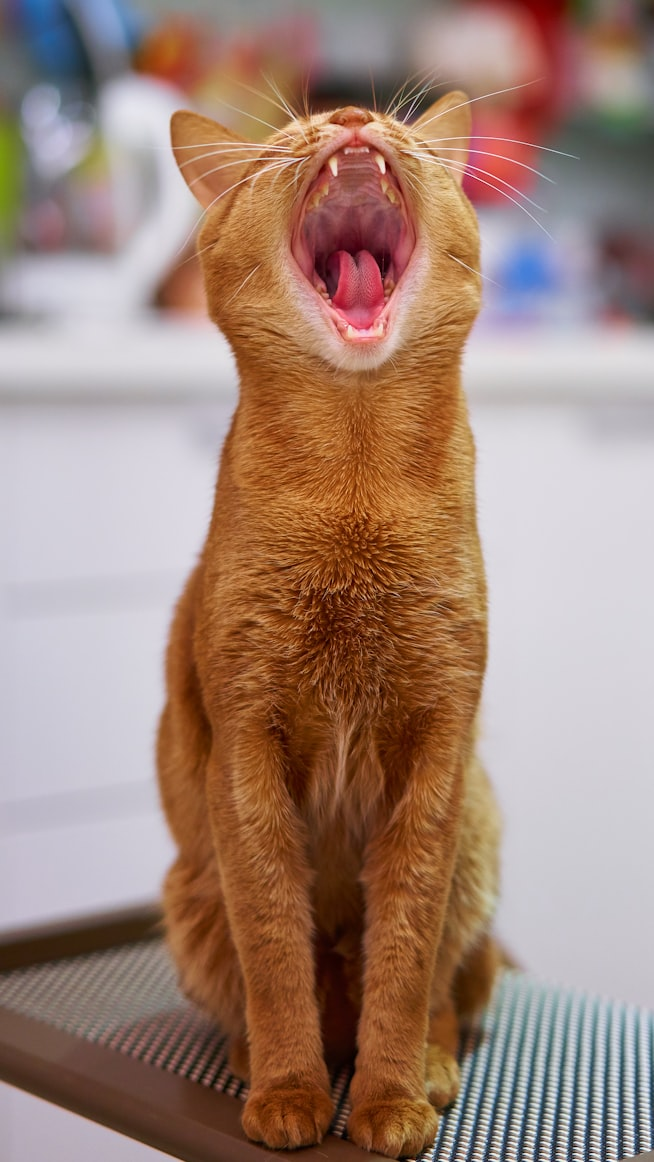

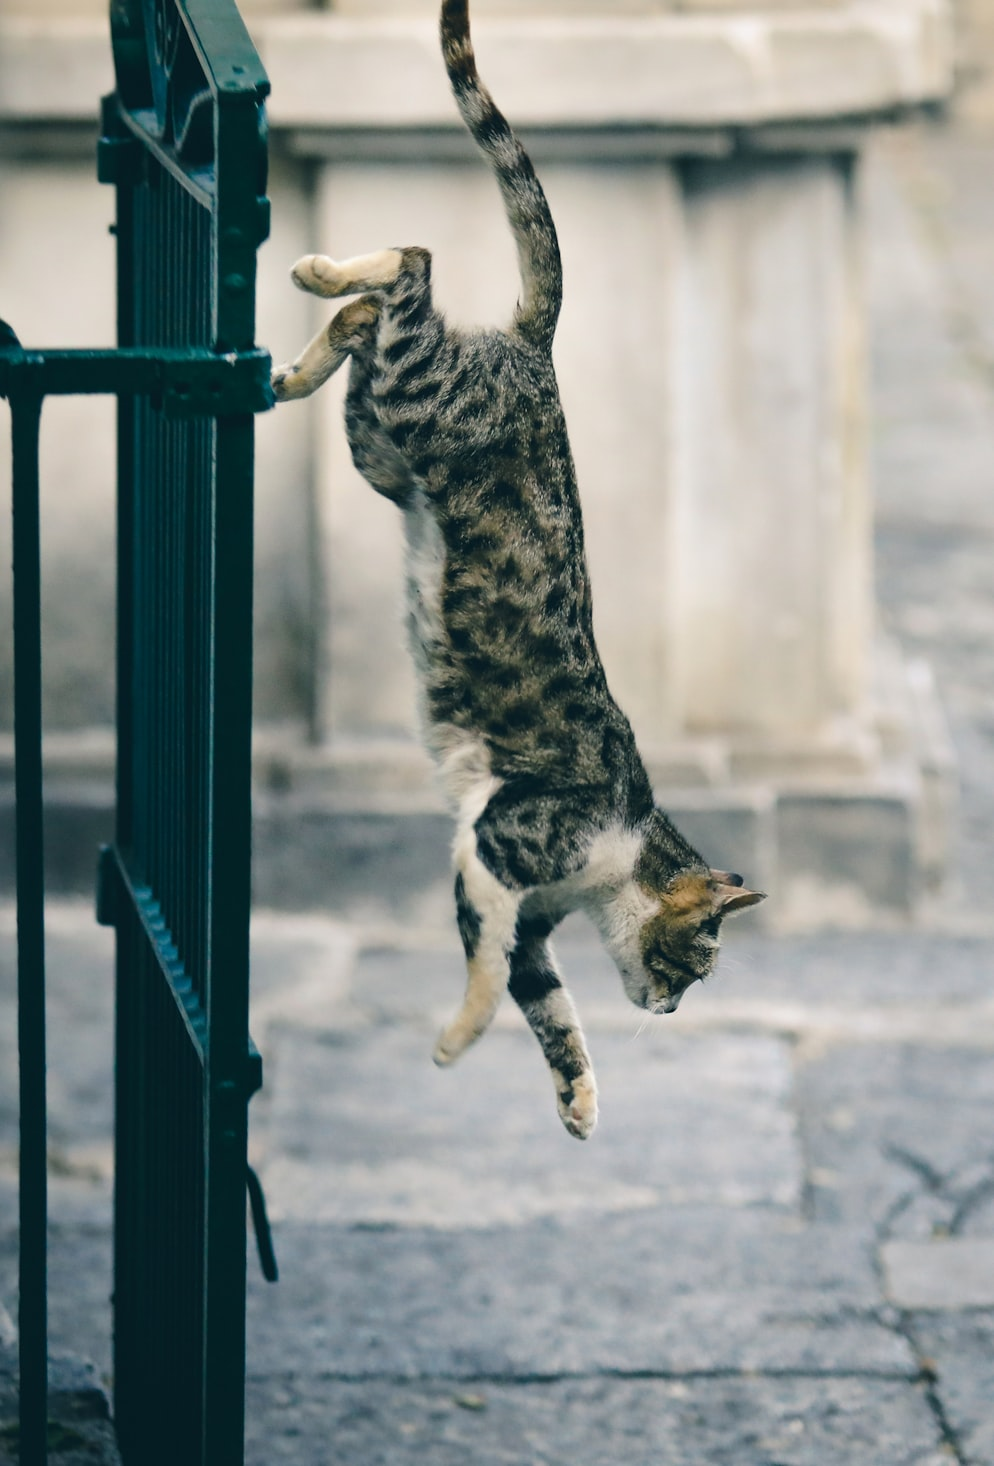

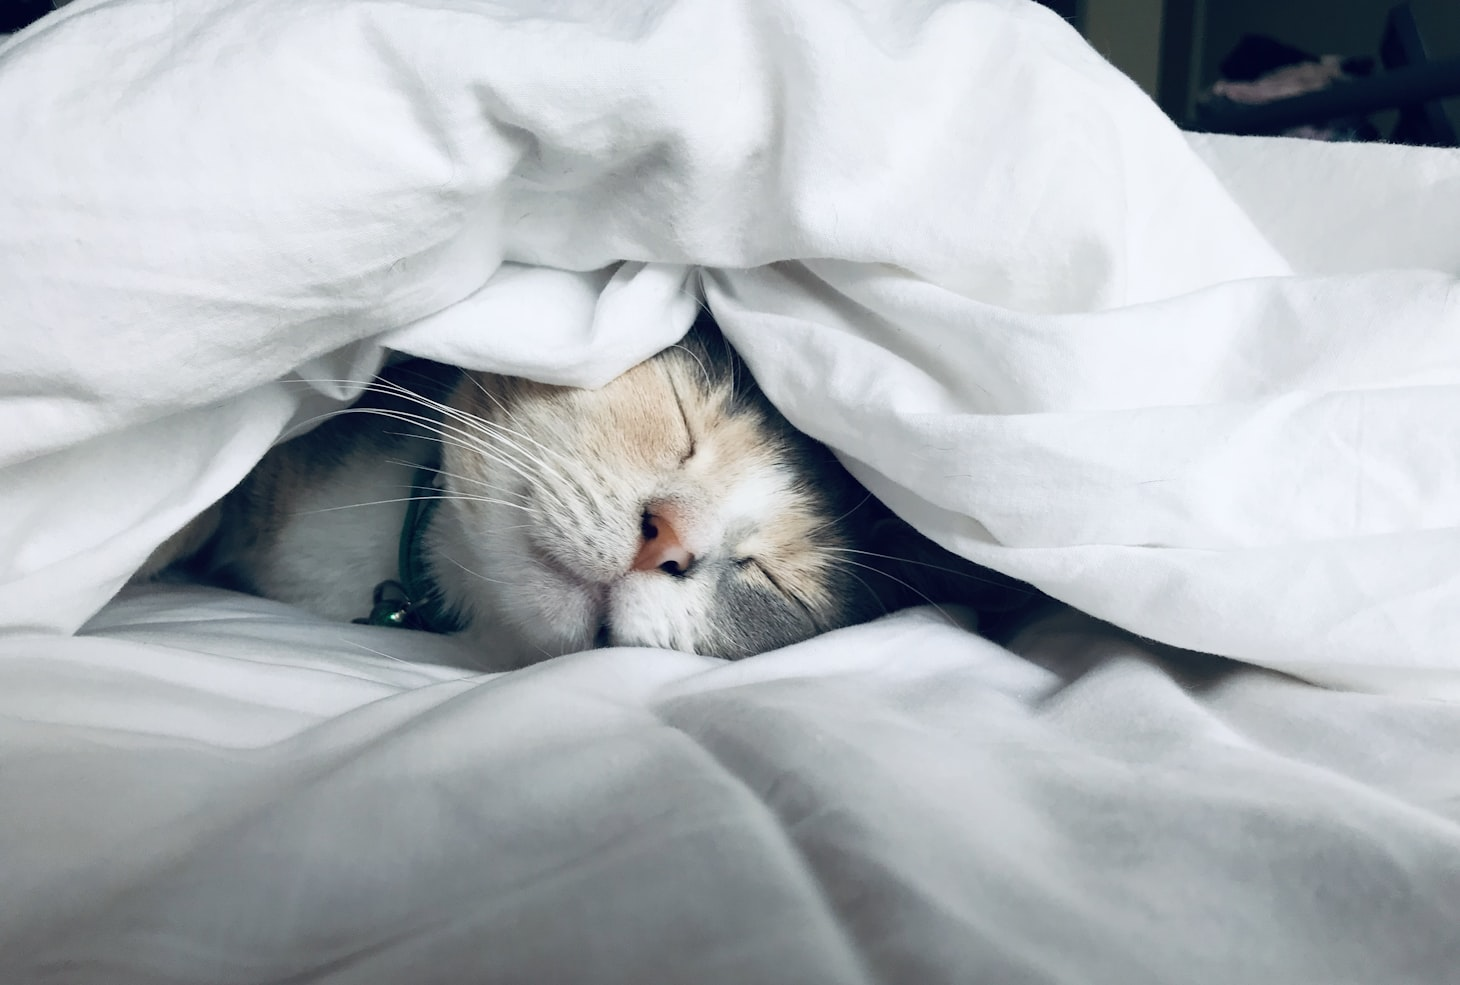

In [ ]:
# Import relevant modules
from PIL import Image
from IPython.display import display
from io import BytesIO
from transformers import CLIPProcessor, CLIPModel
import requests
import matplotlib.pyplot as plt
import numpy as np

urls = [
    "https://images.unsplash.com/photo-1580280949881-ca923b8afda4?q=80&w=654&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D",
    "https://images.unsplash.com/photo-1566513317351-c6d7be11505e?q=80&w=994&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D",
    "https://images.unsplash.com/photo-1541781774459-bb2af2f05b55?q=80&w=1460&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D"
]

#  Take a list of image URLs, download each image, and open them
images = [Image.open(BytesIO(requests.get(url).content)) for url in urls]

# Display images
for image in images:
    display(image)

We want to generate embeddings for these images so we can use the CLIP (Contrastive Language–Image Pre-training) model. We load `CLIPModel` to generate the embeddings and `CLIPProcessor` for preprocessing (e.g. resizing images, etc.).

We create the model and processor. Specifically, we use OpenAI’s model `clip-vit-base-patch32` [7].

In [ ]:
# Load CLIP model and processor
model = CLIPModel.from_pretrained('openai/clip-vit-base-patch32')
processor = CLIPProcessor.from_pretrained('openai/clip-vit-base-patch32')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

We already have the images stored in the variable `images`. So, all that’s left is to create captions. We will create a list of captions containing the true captions as well as fake ones.

In [ ]:
captions = ["a cat sleeping",
            "a cat yawning",
            "a cat jumping",
            "a motorbike on a road",
            "rainbow in the sky",
            "a water bottle"]

We now process the captions and images as follows:

In [ ]:
# Process captions and images
inputs = processor(
    text=captions,         # input the captions
    images=images,         # inputs the images
    return_tensors='pt',   # returns pytorch tensors
    padding=True           # ensures sequences all the same length
)

All that’s left to do is get the predictions and display the results! Let’s get the predictions first.

In [ ]:
# Get predictions
outputs = model(**inputs)
predicts = outputs.logits_per_image.argmax(dim=1)
probas = outputs.logits_per_image / outputs.logits_per_image.sum(axis=1).unsqueeze(1)

Now we can display the images with their corresponding predicted captions.

Caption: "a cat sleeping" Proba: 17.79%
Caption: "a cat yawning" Proba: 23.02%
Caption: "a cat jumping" Proba: 18.90%
Caption: "a motorbike on a road" Proba: 11.05%
Caption: "rainbow in the sky" Proba: 13.60%
Caption: "a water bottle" Proba: 15.64%
Predicted Caption: a cat yawning


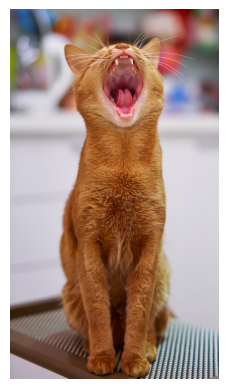

Caption: "a cat sleeping" Proba: 18.95%
Caption: "a cat yawning" Proba: 19.51%
Caption: "a cat jumping" Proba: 23.85%
Caption: "a motorbike on a road" Proba: 11.46%
Caption: "rainbow in the sky" Proba: 12.07%
Caption: "a water bottle" Proba: 14.16%
Predicted Caption: a cat jumping


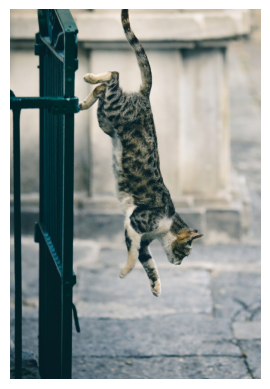

Caption: "a cat sleeping" Proba: 22.78%
Caption: "a cat yawning" Proba: 19.20%
Caption: "a cat jumping" Proba: 17.69%
Caption: "a motorbike on a road" Proba: 10.77%
Caption: "rainbow in the sky" Proba: 14.21%
Caption: "a water bottle" Proba: 15.35%
Predicted Caption: a cat sleeping


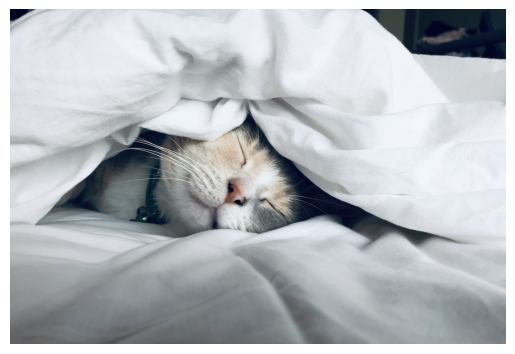

In [ ]:
# Display images with predicted captions
for i, image in enumerate(images):
    argmax = predicts[i].item()
    for c, p in zip(captions, probas[i]):
        print(f'Caption: "{c}" Proba: {p.item():.2%}')
    print(f'Predicted Caption: {captions[argmax]}')
    plt.imshow(np.asarray(image))
    plt.axis('off')
    plt.show()

tensor([[0.1779, 0.2302, 0.1890, 0.1105, 0.1360, 0.1564],
        [0.1895, 0.1951, 0.2385, 0.1146, 0.1207, 0.1416],
        [0.2278, 0.1920, 0.1769, 0.1077, 0.1421, 0.1535]],
       grad_fn=<DivBackward0>)